## Importing packages and data

In [201]:
## Importing packages and data
# Importing libraries
import pandas as pd
import numpy as np

# Configure matplotlib for inline plotting in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()  # Enable interactive mode
from matplotlib import colors
import seaborn as sns
import matplotlib
matplotlib.use('inline')  # or 'Qt5Agg' depending on your system
import json
import os
from pathlib import Path

from subprocess import Popen, PIPE, STDOUT
from glob import glob

import langchain  # Main LangChain import
from langchain_openai import ChatOpenAI  # To work with OpenAI
# from langchain_anthropic import ChatAnthropic # To work with Anthropic (optional)
# from langchain_google_genai import ChatGoogleGenerativeAI # To work with Gemini (optional)
from langchain_core.output_parsers import JsonOutputParser  # To help with structured output
from langchain_core.prompts import PromptTemplate  # To help create our prompt
from langchain_core.pydantic_v1 import BaseModel, Field  # To help with defining what output structure we want
from pydantic import BaseModel

from typing import List, Tuple

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain.load.dump import dumps
from langchain_core.messages import HumanMessage



import logging
import sys

import ast

In [202]:
# ==========================
# Configure Logging
# ==========================

# Create a logger
logger = logging.getLogger('ReWOO_LangGraph')
logger.setLevel(logging.DEBUG)

# Clear any existing handlers attached to the logger
if logger.hasHandlers():
    logger.handlers.clear()

# Create handlers
c_handler = logging.StreamHandler(sys.stdout)
f_handler = logging.FileHandler('rewoolanggraph.log', mode='w')

c_handler.setLevel(logging.INFO)
f_handler.setLevel(logging.DEBUG)

# Create formatters and add them to handlers
c_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)


In [203]:
# ==========================
# Function to load JSON files
# ==========================

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [204]:
# ==========================
# Loading Files
# ==========================

base_path = 'arc-agi-genesis/data/challenges/'

# Subset of challenges for testing
subset_ids_challenges = load_json(base_path + '28_8x10_challenges.json')
subset_ids_evaluation = load_json(base_path + '28_15x15_evaluation.json')

# Load evaluation dataset
evaluation_challenges = load_json(base_path + 'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path + 'arc-agi_evaluation_solutions.json')

# load training dataset
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Filter training challenges and solutions to only include the subset IDs
training_challenges = {k: v for k, v in training_challenges.items() if k in subset_ids_challenges}
training_solutions = {k: v for k, v in training_solutions.items() if k in subset_ids_challenges}

# filter evaluation challenges and solutions to only include the subset IDs
evaluation_challenges = {k: v for k, v in evaluation_challenges.items() if k in subset_ids_evaluation}
evaluation_solutions = {k: v for k, v in evaluation_solutions.items() if k in subset_ids_evaluation}

test_challenges = load_json(base_path + 'arc-agi_test_challenges.json')



task_sets = {
    'training': {
        'challenges': training_challenges,
        'solutions': training_solutions,
    },
    'evaluation': {
        'challenges': evaluation_challenges,
        'solutions': evaluation_solutions,
    }
}

In [205]:
# ==========================
# Function to load tasks from a pre-loaded task set
# ==========================

def load_tasks_from_file(task_set):
    """
    Loads the tasks from the pre-loaded JSON data and returns the challenges and solutions tasks.
    """
    challenges = task_set['challenges']
    solutions = task_set['solutions']

    return challenges, solutions

In [206]:
# ==========================
# Print Dataset Information
# ==========================

print(f'Number of filtered training challenges = {len(training_challenges)}')
print(f'Number of filtered training solutions = {len(training_solutions)}')

# Loading tasks from the 'training' task set
challenges, solutions = load_tasks_from_file(task_set=task_sets['training'])
print(json.dumps(challenges['0520fde7'], indent=2))  # Accessing a specific challenge

Number of filtered training challenges = 28
Number of filtered training solutions = 28
{
  "test": [
    {
      "input": [
        [
          1,
          0,
          1,
          5,
          1,
          0,
          1
        ],
        [
          0,
          1,
          0,
          5,
          1,
          0,
          1
        ],
        [
          1,
          0,
          1,
          5,
          0,
          1,
          0
        ]
      ]
    }
  ],
  "train": [
    {
      "input": [
        [
          1,
          0,
          0,
          5,
          0,
          1,
          0
        ],
        [
          0,
          1,
          0,
          5,
          1,
          1,
          1
        ],
        [
          1,
          0,
          0,
          5,
          0,
          0,
          0
        ]
      ],
      "output": [
        [
          0,
          0,
          0
        ],
        [
          0,
          2,
          0
        ],
        [
  

#### initializing LLM client to use

In [207]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('api.env')

# Get the OpenAI API key from environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')

# Initialize the ChatOpenAI model with the API key
llm = ChatOpenAI(model='gpt-4o-mini', openai_api_key=openai_api_key, max_tokens=3000)

## And incase you want to try Anthropic
# llm = ChatAnthropic(model='claude-3-5-sonnet-20240620', api_key=UserSecretsClient().get_secret("ANTHROPIC_API_KEY"), max_tokens=3000)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", google_api_key=UserSecretsClient().get_secret("GOOGLE_API_KEY"), max_tokens=3000)

### Function for visualizing the tasks

In [208]:
# ==========================
# Functions to visualize tasks
# ==========================

cmap = colors.ListedColormap(
   ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#FFFFFF'])
norm = colors.Normalize(vmin=0, vmax=10)
# print(norm)

def plot_one(ax, i, task, train_or_test, input_or_output):
    # Check if input_or_output is 'solution' or 'predicted_solution'
    if input_or_output == 'solution':
        input_matrix = task[train_or_test][i]['output']  # Assuming this is the ground truth solution
    elif input_or_output == 'predicted_solution':
        input_matrix = task.get('prediction', [])[i]  # Access the predicted solution from task
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x - 0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x - 0.5 for x in range(1 + len(input_matrix))])
    ax.set_title(f"{train_or_test} {input_or_output}")
    return None

   
def plot_eval(task, text, test_input, predicted_solution, actual_solution):
    """
    Plots a single row with three columns: input, predicted solution, and actual solution.
    """
    try:
        # Convert inputs to numpy arrays if they aren't already
        test_input = np.array(test_input)
        predicted_solution = np.array(predicted_solution)
        actual_solution = np.array(actual_solution)
        
        plt.close('all')  # Close any existing plots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{text}', fontsize=16, fontweight='bold')

        # Plot evaluation input
        axs[0].imshow(test_input, cmap=cmap, norm=norm)
        axs[0].set_title('Evaluation Input')
        axs[0].grid(True, color='lightgrey', linewidth=0.5)
        axs[0].set_xticks([x - 0.5 for x in range(1 + len(test_input[0]))]) 
        axs[0].set_yticks([x - 0.5 for x in range(1 + len(test_input))])

        # Plot model's predicted solution
        axs[1].imshow(predicted_solution, cmap=cmap, norm=norm)
        axs[1].set_title('Model Prediction')
        axs[1].grid(True, color='lightgrey', linewidth=0.5)
        axs[1].set_xticks([x - 0.5 for x in range(1 + len(predicted_solution[0]))]) 
        axs[1].set_yticks([x - 0.5 for x in range(1 + len(predicted_solution))])

        # Plot actual solution
        axs[2].imshow(actual_solution, cmap=cmap, norm=norm)
        axs[2].set_title('Actual Solution')
        axs[2].grid(True, color='lightgrey', linewidth=0.5)
        axs[2].set_xticks([x - 0.5 for x in range(1 + len(actual_solution[0]))]) 
        axs[2].set_yticks([x - 0.5 for x in range(1 + len(actual_solution))])

        # Add value annotations to each cell
        for ax, data in zip(axs, [test_input, predicted_solution, actual_solution]):
            for i in range(len(data)):
                for j in range(len(data[0])):
                    ax.text(j, i, str(data[i][j]), 
                           ha='center', va='center',
                           color='white' if data[i][j] in [0, 1, 9] else 'black')

        plt.tight_layout()
        plt.show()
        plt.close()  # Close the plot after showing it
        
    except Exception as e:
        logger.error(f"Error in plot_eval: {str(e)}")
        plt.close('all')  # Clean up any partial plots
 
def plot_task(task1, text):    
    num_train = len(task1['train'])
    w=num_train
    fig, axs  = plt.subplots(2, w, figsize=(3*w ,3*2))
    plt.suptitle(f'{text}:', fontsize=20, fontweight='bold', y=1)

    for j in range(num_train):     
        plot_one(axs[0, j], j,task1,'train', 'input')
        plot_one(axs[1, j], j,task1,'train', 'output')  
    
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
    plt.tight_layout()
    # plt.show()
    return plt    
    
def openai_encode_image_base64(plt):
    import io
    plt_stringIObytes = io.BytesIO()
    plt.savefig(plt_stringIObytes, format='png')
    plt_stringIObytes.seek(0)
    base64_image = base64.b64encode(plt_stringIObytes.read()).decode('utf-8')
    return {
      "type": "image_url",
      "image_url": {
        "url": f"data:image/jpeg;base64,{base64_image}"
      }
    }

## Trying to make MVP product which is just regular openai model trying to predict 

In [209]:
# converting train and test pairs to a string format ideal for LLMs
def json_task_to_string(challenge_tasks: dict, task_id: str, test_input_index: int) -> str:
    """
    challenge_tasks: dict a list of tasks
    task_id: str the id of the task we want to convert to a string
    
    Convert your json task into a string so you can pass it to your LLM.
    This is a crucial step where you can use your creativity to edit how tasks are represented.
    """
    json_task = challenge_tasks[task_id]

    final_output = ""

    train_tasks = json_task['train']
    test_task = json_task['test']

    final_output = "Training Examples\n"

    for i, task in enumerate(train_tasks):
        final_output += f"Example {i + 1}: Input\n["
        for row in task['input']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"
        final_output += f"Example {i + 1}: Output\n["

        for row in task['output']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"

    final_output += "Test\n["
    for row in test_task[test_input_index]['input']:
        final_output += f"\n{str(row)}"

    final_output += "]\n\nYour Response:"

    return final_output

In [210]:
# an example of how the function works
task_string = json_task_to_string(challenges, '0520fde7', 0)
print (task_string)

Training Examples
Example 1: Input
[
[1, 0, 0, 5, 0, 1, 0],
[0, 1, 0, 5, 1, 1, 1],
[1, 0, 0, 5, 0, 0, 0],]

Example 1: Output
[
[0, 0, 0],
[0, 2, 0],
[0, 0, 0],]

Example 2: Input
[
[1, 1, 0, 5, 0, 1, 0],
[0, 0, 1, 5, 1, 1, 1],
[1, 1, 0, 5, 0, 1, 0],]

Example 2: Output
[
[0, 2, 0],
[0, 0, 2],
[0, 2, 0],]

Example 3: Input
[
[0, 0, 1, 5, 0, 0, 0],
[1, 1, 0, 5, 1, 0, 1],
[0, 1, 1, 5, 1, 0, 1],]

Example 3: Output
[
[0, 0, 0],
[2, 0, 0],
[0, 0, 2],]

Test
[
[1, 0, 1, 5, 1, 0, 1]
[0, 1, 0, 5, 1, 0, 1]
[1, 0, 1, 5, 0, 1, 0]]

Your Response:


In [211]:
# Using a json output parser to parse the output, since LLMs aren't perfect at generating valid json
# Defining a prediction as a list of lists
class ARCPrediction(BaseModel):
    prediction: List[List] = Field(..., description="A prediction for a task")

## Setting up langgraph for mUlTiaGenTiC sYstEM

In [212]:
# Setting up the state for the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    patterns: Annotated[list, add_messages]
    code: str
    prediction: List[List]
    task_string: str
    task_data: dict
    test_input_index: int



#### Generating nodes

In [213]:
# Building nodes for the graph
# first initialize the StateGraph
graph_builder = StateGraph(State)
import ast

# ==========================
# Function to get the grid size prediction. Has 86% accuracy on the training set.
# ==========================
def predict_task_grid_size(train_inputs, train_outputs, test_inputs):
    """
    Predicts the grid size of test inputs based on patterns from the train inputs and outputs.

    Args:
    - train_inputs: List of 2D arrays representing the input grids for training.
    - train_outputs: List of 2D arrays representing the output grids for training.
    - test_inputs: List of 2D arrays representing the input grids for testing.

    Returns:
    - pred_test_sizes: List of predicted sizes for the test outputs in 'WxH' format (e.g., '6x6').
    """

    # Calculate the sizes of train inputs and outputs
    train_in_size = [[len(i[0]), len(i)] for i in train_inputs]
    train_out_size = [[len(i[0]), len(i)] for i in train_outputs]

    # Calculate the sizes of test inputs
    test_in_size = [[len(i[0]), len(i)] for i in test_inputs]

    # Try to detect consistent ratio patterns
    ratio_x = train_in_size[0][0] / train_out_size[0][0]
    ratio_y = train_in_size[0][1] / train_out_size[0][1]

    # Check for consistent ratios in the training set
    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] / out_size[0] != ratio_x or in_size[1] / out_size[1] != ratio_y:
            break
    else:
        # If the ratio holds, predict based on the ratio
        pred_test_sizes = [f"{int(i[0] / ratio_x)}x{int(i[1] / ratio_y)}" for i in test_in_size]
        return pred_test_sizes

    # If ratio-based prediction fails, check for consistent subtraction patterns
    sub_x = train_in_size[0][0] - train_out_size[0][0]
    sub_y = train_in_size[0][1] - train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] - out_size[0] != sub_x or in_size[1] - out_size[1] != sub_y:
            break
    else:
        # If subtraction holds, predict based on subtraction
        pred_test_sizes = [f"{i[0] - sub_x}x{i[1] - sub_y}" for i in test_in_size if i[0] - sub_x > 0 and i[1] - sub_y > 0]
        return pred_test_sizes

    # If subtraction-based prediction fails, predict based on the size of the last output grid
    last_x = train_out_size[0][0]
    last_y = train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if out_size[0] != last_x or out_size[1] != last_y:
            break
    else:
        # If all output grids are the same size, predict this size for all test inputs
        pred_test_sizes = [f"{last_x}x{last_y}" for _ in test_in_size]
        return pred_test_sizes

    # If no pattern holds, return 'Unknown' indicating an unknown prediction
    pred_test_sizes = ['Unknown' for _ in test_in_size]
    return pred_test_sizes



# ==========================
# Helper Function to Convert Messages
# ==========================

def convert_messages(message_list):
    return [
        msg.content if isinstance(msg, (AIMessage, HumanMessage)) else str(msg)
        for msg in message_list
    ]

def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

# ==========================
# execute_code with Syntax Checking and Logging
# ==========================

def execute_code(state: State):
    code = state['code']
    task_data = state['task_data']

    test_input_index = state['test_input_index']
    test_input = task_data['test'][test_input_index]['input']

    # Log the code for debugging
    logger.debug(f"Executing code:\n{code}")

    # Syntax check
    try:
        ast.parse(code)
    except SyntaxError as se:
        logger.error(f"Syntax error in generated code: {se.text}\n"
                     f"Error at line {se.lineno}, column {se.offset}\n"
                     f"Line content: {se.text}")
        return {"prediction": [], "revised_code": code}

    local_vars = {}
    global_vars = {}

    try:
        exec(code, global_vars, local_vars)
        if 'solve_task' in local_vars:
            solve_task = local_vars['solve_task']
        elif 'solve_task' in global_vars:
            solve_task = global_vars['solve_task']
        else:
            raise Exception("solve_task function not defined in code.")

        prediction = solve_task(test_input)
    except Exception as e:
        prediction = []
        logger.error(f"Error executing code: {e}")

    return {"prediction": prediction, "revised_code": code}

# ==========================
# generate_code with Enhanced Prompt
# ==========================

import re  # Import this at the top of your file to use regex for stripping

def clean_code_output(code: str) -> str:
    """
    Function to clean up the code generated by the LLM.
    Strips out markdown-like syntax like ```python and ```.
    """
    # Use regex to remove markdown code block markers and unnecessary spaces
    cleaned_code = re.sub(r'```[\w]*', '', code).strip()
    return cleaned_code

def generate_code(state: State):
    patterns = state['patterns'][-1]  # Get the last patterns added

    prompt = PromptTemplate(
        template=(
            "You are an expert Python programmer.\n\n"
            "Given the following patterns, write Python code that solves the task according to these patterns.\n"
            "The code should define a function `solve_task(input_grid)` that returns the output grid.\n"
            "Ensure the code is syntactically correct and free of any errors.\n\n"
            "**ONLY** return the code without any additional explanations.\n\n"
            "Patterns:\n{patterns}\n\n"
            "Your code:"
        ),
        input_variables=["patterns"]
    )

    chain = prompt | llm
    code = chain.invoke({"patterns": patterns}).content.strip()

    # Clean up the generated code by removing any markdown formatting
    cleaned_code = clean_code_output(code)

    return {"code": cleaned_code}

def revise_code(state: State):
    code = state['code']

    prompt = PromptTemplate(
        template=(
            "Review the following Python code and improve it if necessary.\n"
            "Ensure that it correctly implements the desired functionality and handles edge cases.\n\n"
            "**ONLY** return the revised code without any explanations or comments.\n\n"
            "Code:\n{code}\n\n"
            "Revised code:"
        ),
        input_variables=["code"]
    )

    chain = prompt | llm
    revised_code = chain.invoke({"code": code}).content.strip()

    # Clean up the revised code by removing any markdown formatting
    cleaned_revised_code = clean_code_output(revised_code)

    return {"code": cleaned_revised_code}


# ==========================
# identify_logic Function
# ==========================

def identify_logic(state: State):
    task_string = state['task_string']
    predicted_grid_size = state.get('predicted_grid_size', 'Unknown')  # Retrieve the predicted grid size from the state
    
    # Add the grid size information to the prompt for the LLM
    logger.info(f"Identifying logic for task: {task_string} with predicted grid size: {predicted_grid_size}")
    prompt = PromptTemplate(
        template=(
            "You are an AI assistant specializing in puzzle solving.\n\n"
            "The predicted grid size for this task is {predicted_grid_size}.\n"
            "Given the following task, identify the logic or pattern present in the training examples.\n"
            "Provide a brief description of the logic in bullet points.\n\n"
            "Task:\n{task_string}\n\n"
            "Your response should be a brief description of the logic."
        ),
        input_variables=["task_string", "predicted_grid_size"]
    )

    chain = prompt | llm
    output = chain.invoke({
        "task_string": task_string,
        "predicted_grid_size": predicted_grid_size
    }).content

    # Return as AIMessage object
    return {"messages": [AIMessage(content=output)]}


# ==========================
# recognize_patterns Function
# ==========================

def recognize_patterns(state: State):
    messages = state['messages']
    previous_analysis = messages[-1]  # Already converted to string in get_task_prediction

    prompt = PromptTemplate(
        template=(
            "Based on the previous analysis, identify detailed patterns in the task.\n"
            "Focus on visual patterns, JSON structures, or any other relevant aspects.\n"
            "Provide the patterns as a list of concise statements.\n\n"
            "Previous analysis:\n{previous_analysis}\n\n"
            "Your response should be a list of patterns."
        ),
        input_variables=["previous_analysis"]
    )

    chain = prompt | llm
    output = chain.invoke({"previous_analysis": previous_analysis}).content

    return {"patterns": [output]}


#### Building the graph with eches

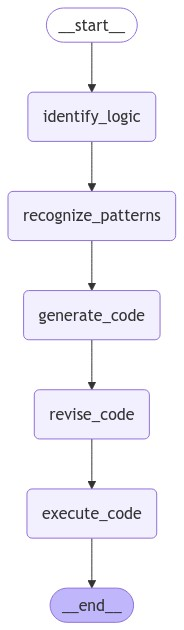

In [214]:
graph_builder.add_node("identify_logic", identify_logic)
graph_builder.add_node("recognize_patterns", recognize_patterns)
graph_builder.add_node("generate_code", generate_code)
graph_builder.add_node("revise_code", revise_code)
graph_builder.add_node("execute_code", execute_code)

graph_builder.add_edge(START, "identify_logic")
graph_builder.add_edge("identify_logic", "recognize_patterns")
graph_builder.add_edge("recognize_patterns", "generate_code")
graph_builder.add_edge("generate_code", "revise_code")
graph_builder.add_edge("revise_code", "execute_code")
graph_builder.add_edge("execute_code", END)

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Creating function to get task prediction, make prompt, make API calls to model and parse output with retries

In [215]:
def get_task_prediction(challenge_tasks, solutions, task_id, test_input_index, plot=False):
    task_string = json_task_to_string(challenge_tasks, task_id, test_input_index)
    task_data = challenge_tasks[task_id]
    
    train_tasks = task_data['train']
    train_inputs = [t['input'] for t in train_tasks]
    train_outputs = [t['output'] for t in train_tasks]
    test_input = task_data['test'][test_input_index]['input']
    
    # Ensure you have the actual solution
    actual_solution = solutions.get(task_id, [])[test_input_index]
    
    # Predict the grid size
    predicted_grid_size = predict_task_grid_size(train_inputs, train_outputs, [test_input])[0]

    initial_state = {
        'task_string': task_string,
        'task_data': task_data,
        'test_input_index': test_input_index,
        'predicted_grid_size': predicted_grid_size,
        'messages': [],
        'patterns': [],
        'code': '',
        'revised_code': '',
        'prediction': []
    }

    # Invoke the graph or prediction model
    final_state = graph.invoke(initial_state)
    predicted_solution = final_state.get('prediction', [])

    # Add debugging print statements
    if plot:
        try:
            print("Debug - Plotting dimensions:")
            print(f"Test input shape: {np.array(test_input).shape}")
            print(f"Predicted solution shape: {np.array(predicted_solution).shape}")
            print(f"Actual solution shape: {np.array(actual_solution).shape}")
            
            # Only plot if we have valid arrays
            if len(predicted_solution) > 0:
                logger.info(f"Plotting results for task {task_id}, attempt {test_input_index}")
                plot_eval(task_data, f"Task {task_id} Attempt", test_input, predicted_solution, actual_solution)
            else:
                logger.warning("Skipping plot - predicted solution is empty")
        except Exception as e:
            logger.error(f"Error during plotting: {str(e)}")
            plt.close('all')  # Clean up any partial plots

    # Extract messages and return structured output
    messages = final_state.get('messages', [])
    if messages:
        messages = [msg.content if isinstance(msg, AIMessage) else msg for msg in messages]

    output_details = {
        'messages': messages,
        'patterns': final_state.get('patterns', []),
        'code': final_state.get('code', ''),
        'revised_code': final_state.get('revised_code', ''),
        'prediction': predicted_solution
    }

    return output_details

In [216]:
def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

def run_model(challenges, solutions, NUM_ATTEMPTS=2, RETRY_ATTEMPTS=3, NUM_TASKS=None):
    submission = {}
    detailed_outputs = {}

    for i, task_id in enumerate(challenges):
        task_attempts = []
        detailed_outputs[task_id] = []

        # Iterate through each test pair for a prediction
        for t, pair in enumerate(challenges[task_id]['test']):
            logger.info(f"Starting task #{i + 1} ({task_id}), pair #{t+1}")

            pair_attempts = {}
            pair_detailed = {}

            # Make attempts with retries
            for attempt in range(1, NUM_ATTEMPTS + 1):
                attempt_key = f"attempt_{attempt}"
                pair_attempts[attempt_key] = []
                pair_detailed[attempt_key] = {}

                # Run retries within the attempt
                for retry in range(RETRY_ATTEMPTS):
                    # Always plot in notebook
                    should_plot = True
                    logger.info(f"Plot flag for task {task_id}, attempt {attempt}, retry {retry}: {should_plot}")

                    try:
                        prediction_details = get_task_prediction(
                            challenge_tasks=challenges,
                            solutions=solutions,
                            task_id=task_id,
                            test_input_index=t,
                            plot=should_plot
                        )

                        # Print prediction details for debugging
                        print(f"\nPrediction details for {attempt_key}, retry {retry}:")
                        print(f"Prediction: {prediction_details['prediction']}")
                        print(f"Expected solution: {solutions[task_id][t]}")

                        # Store valid prediction and exit retry loop on success
                        if prediction_details['prediction']:  # Only store if we have a prediction
                            pair_attempts[attempt_key] = prediction_details['prediction']
                            pair_detailed[attempt_key] = prediction_details
                            
                            # Check if prediction matches solution
                            if prediction_details['prediction'] == solutions[task_id][t]:
                                print(f"Found correct solution in {attempt_key}, retry {retry}")
                                break
                            
                        break  # Exit retry loop if we got any valid prediction
                    except Exception as e:
                        logger.warning(f"Retrying: {e}")
                        if retry == RETRY_ATTEMPTS - 1:
                            pair_attempts[attempt_key] = []
                            pair_detailed[attempt_key] = {'error': str(e)}

            task_attempts.append(pair_attempts)
            detailed_outputs[task_id].append(pair_detailed)

        submission[task_id] = task_attempts

        if NUM_TASKS is not None and i + 1 == NUM_TASKS:
            break

    # Save detailed outputs
    serializable_outputs = make_serializable(detailed_outputs)
    with open('detailed_outputs.json', 'w') as f:
        # Fix: Use serializable_outputs instead of serialized_outputs
        json.dump(serializable_outputs, f, indent=2)  # Also changed dumps to dump


    return submission

### Creating submission files and comparing it with solutions file

In [217]:
# create submission file
def create_submission_file(submission, file_name='submission.json'):
    """
    Save a submission file to the specified file name
    """
    with open(file_name, "w") as file:
        json.dump(submission, file)

    print (f"Submission saved to {file_name}")

In [218]:
# create function to compare submission with solutions
def score_submission(submission_file_name, solutions) -> Tuple[float, int]:
    """
    submission_file_name: str, the file name of your submission file
    solutions: dict, the ground truth solutions you'd like to test against
    """
    print(f"Scoring {submission_file_name}\n")

    # Open your submission file
    with open(submission_file_name, "r") as file:
        submission = json.load(file)

    total_score = 0
    total_tasks = 0

    # Add debugging prints
    print("Submission contents:")
    print(json.dumps(submission, indent=2))
    print("\nSolutions contents:")
    print(json.dumps(solutions, indent=2))

    # Loop through each task in your submission to grade it
    for task_id, task_submission in submission.items():
        total_tasks += 1
        task_score = 0
        num_pairs = len(task_submission)

        print(f"\nScoring task {task_id}:")
        print(f"Number of test pairs: {num_pairs}")

        # Go through each task. Most will only have 1
        for pair_index, pair_attempts in enumerate(task_submission):
            print(f"\nScoring Task {task_id} pair #{pair_index+1}")
            print(f"Attempts available: {list(pair_attempts.keys())}")
            pair_correct = False

            # Look at both of your attempts
            for attempt_key, attempt in pair_attempts.items():
                print(f"\nChecking {attempt_key}:")
                print(f"Attempt solution: {attempt}")
                print(f"Correct solution: {solutions[task_id][pair_index]}")
                
                # check to see if one is correct
                if attempt == solutions[task_id][pair_index]:
                    print(f"Task Id {task_id} pair {pair_index+1} {attempt_key} matches solution")
                    pair_correct = True
                    break # If it is correct, log it and break the loop

            if pair_correct:
                task_score += 1
                print(f"Pair {pair_index+1} is correct")
            else:
                print(f"Pair {pair_index+1} is incorrect")

        task_score /= num_pairs
        total_score += task_score
        print(f"\nTask {task_id} score: {task_score}")

    final_score = {
        'total_score': total_score,
        'total_tasks_scored': total_tasks,
        'percentage': round(total_score / total_tasks * 100, 2) if total_tasks > 0 else 0
    }
    
    print(f"\nFinal scoring results:")
    print(f"Total score: {final_score['total_score']}")
    print(f"Total tasks: {final_score['total_tasks_scored']}")
    print(f"Percentage: {final_score['percentage']}%")

    return final_score

#### The main function to bring everything together

In [219]:
def main(task_set='training', NUM_TASKS=None, submission_file_name='submission.json'):
    # Load datasets
    challenges, solutions = load_tasks_from_file(task_set=task_sets[task_set])

    # Run the model, passing both challenges and solutions
    submission = run_model(challenges, solutions, NUM_TASKS=NUM_TASKS)

    # Create (and overwrite) a submission file
    create_submission_file(submission, file_name=submission_file_name)

    # Score the submission
    score_result = score_submission(submission_file_name=submission_file_name, solutions=solutions)

    logger.info(f"Final score: {score_result['total_score']} of {score_result['total_tasks_scored']} ({round(score_result['total_score'] / score_result['total_tasks_scored'] * 100, 2)}%)")

    # Optionally, load and display detailed outputs
    try:
        with open('detailed_outputs.json', 'r') as f:
            detailed_outputs = json.load(f)
        # For example, print the detailed outputs
        # print(json.dumps(detailed_outputs, indent=2))
    except Exception as e:
        logger.error(f"Error loading detailed outputs: {e}")


# RUNNING THE MODEL

2024-10-28 13:58:14,113 - INFO - Starting task #1 (00576224), pair #1
2024-10-28 13:58:14,114 - INFO - Plot flag for task 00576224, attempt 1, retry 0: True
2024-10-28 13:58:14,116 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response: with predicted grid size: Unknown
Debug - Plotting dimensions:
Test input shape: (2, 2)
Predicted solution shape: (6, 6)
Actual solution shape: (6, 6)
2024-10-28 13:58:24,603 - INFO - Plotting results for task 00576224, attempt 0


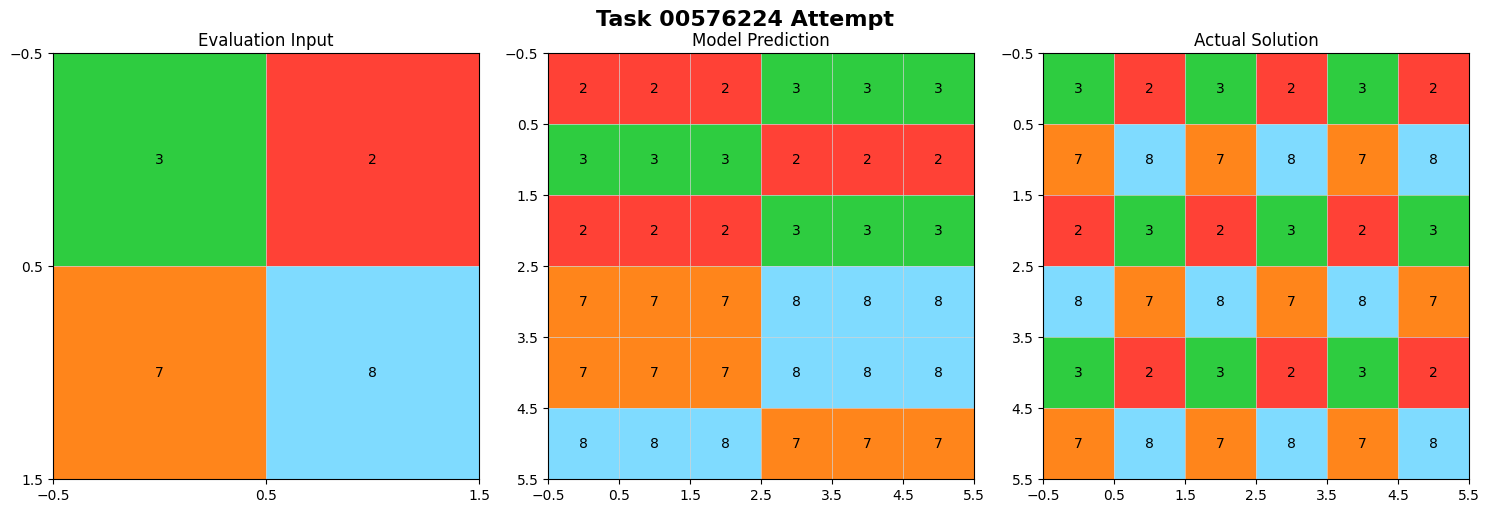


Prediction details for attempt_1, retry 0:
Prediction: [[2, 2, 2, 3, 3, 3], [3, 3, 3, 2, 2, 2], [2, 2, 2, 3, 3, 3], [7, 7, 7, 8, 8, 8], [7, 7, 7, 8, 8, 8], [8, 8, 8, 7, 7, 7]]
Expected solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
2024-10-28 13:58:24,890 - INFO - Plot flag for task 00576224, attempt 2, retry 0: True
2024-10-28 13:58:24,892 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response: with predicted grid size: Unknown
Debug - Plotting dimensions:
Test input shape: (2, 2)
Predicted solution shape: (6, 6)


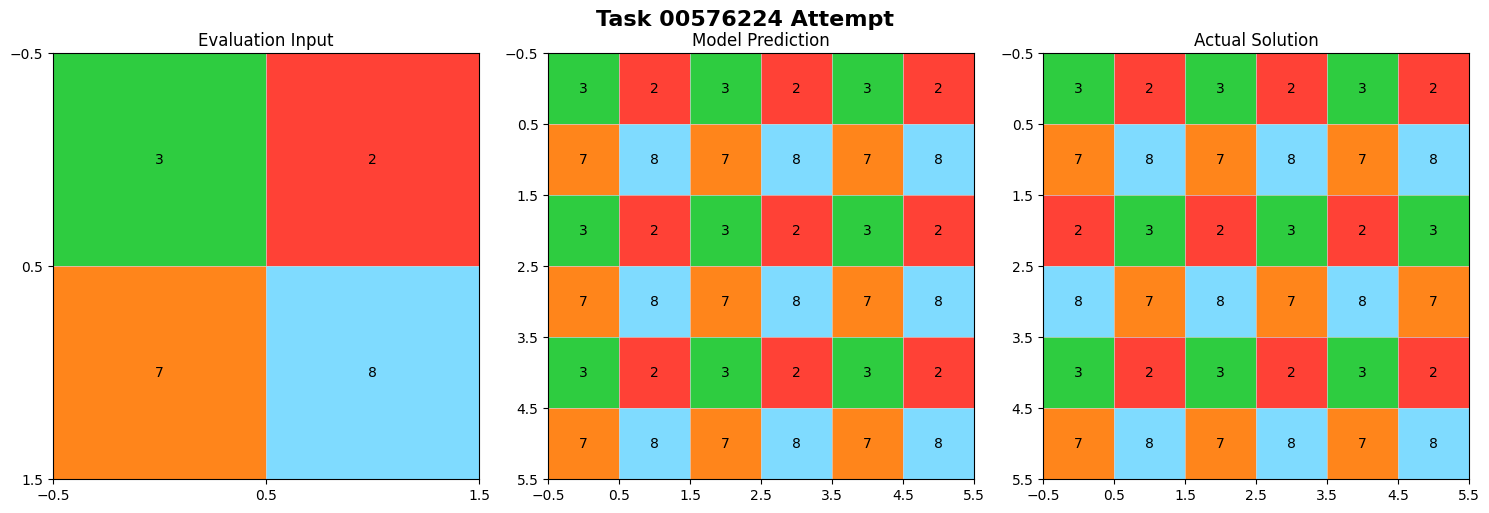


Prediction details for attempt_2, retry 0:
Prediction: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
Expected solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
2024-10-28 13:58:33,927 - INFO - Starting task #2 (17cae0c1), pair #1
2024-10-28 13:58:33,928 - INFO - Plot flag for task 17cae0c1, attempt 1, retry 0: True
2024-10-28 13:58:33,929 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[5, 5, 5, 0, 0, 0, 0, 0, 5],
[5, 0, 5, 0, 5, 0, 0, 5, 0],
[5, 5, 5, 0, 0, 0, 5, 0, 0],]

Example 1: Output
[
[3, 3, 3, 4, 4, 4, 9, 9, 9],
[3, 3, 3, 4, 4, 4, 9, 9, 9],
[3, 3, 3, 4, 4, 4, 9, 9, 9],]

Example 2: Input
[
[0, 0, 5, 0, 0, 0, 0, 0, 0],
[0, 5, 0, 0, 0, 0, 0, 5, 0],
[5, 0, 0, 5, 5, 5, 0, 0, 0],]

Example 2: Output
[
[9, 9, 9, 1, 1, 1, 4, 4, 4],
[9, 9, 9, 1, 1, 1, 4, 4, 4],
[9, 9, 9, 1, 1, 1, 4, 4, 4],]

Example 3: In

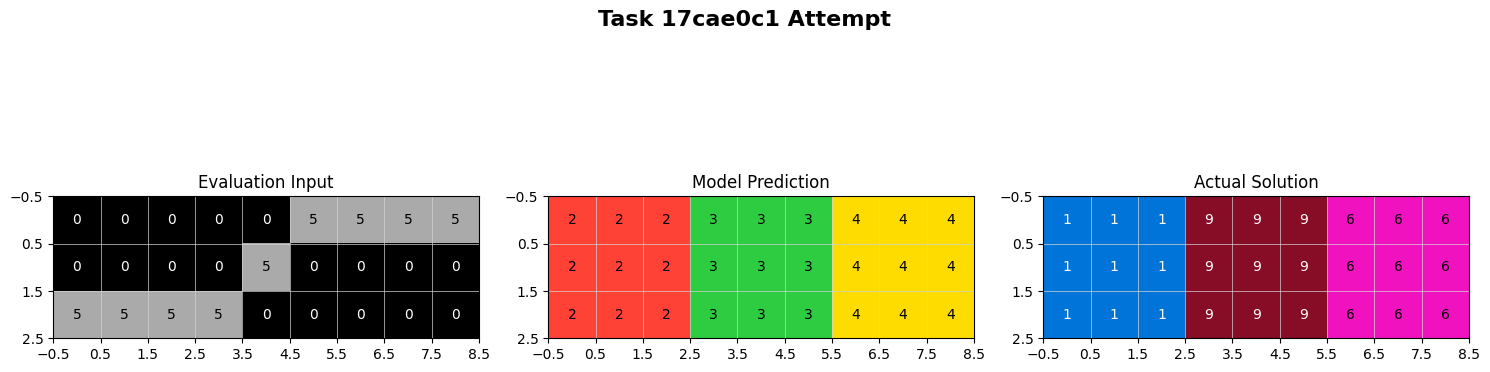


Prediction details for attempt_1, retry 0:
Prediction: [[2, 2, 2, 3, 3, 3, 4, 4, 4], [2, 2, 2, 3, 3, 3, 4, 4, 4], [2, 2, 2, 3, 3, 3, 4, 4, 4]]
Expected solution: [[1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6]]
2024-10-28 13:58:45,201 - INFO - Plot flag for task 17cae0c1, attempt 2, retry 0: True
2024-10-28 13:58:45,204 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[5, 5, 5, 0, 0, 0, 0, 0, 5],
[5, 0, 5, 0, 5, 0, 0, 5, 0],
[5, 5, 5, 0, 0, 0, 5, 0, 0],]

Example 1: Output
[
[3, 3, 3, 4, 4, 4, 9, 9, 9],
[3, 3, 3, 4, 4, 4, 9, 9, 9],
[3, 3, 3, 4, 4, 4, 9, 9, 9],]

Example 2: Input
[
[0, 0, 5, 0, 0, 0, 0, 0, 0],
[0, 5, 0, 0, 0, 0, 0, 5, 0],
[5, 0, 0, 5, 5, 5, 0, 0, 0],]

Example 2: Output
[
[9, 9, 9, 1, 1, 1, 4, 4, 4],
[9, 9, 9, 1, 1, 1, 4, 4, 4],
[9, 9, 9, 1, 1, 1, 4, 4, 4],]

Example 3: Input
[
[5, 5, 5, 5, 5, 5, 0, 0, 0],
[0, 0, 0, 5, 0, 5, 0, 0, 0],
[0, 0, 0, 5, 5, 5, 5, 5, 5],]

Example 3: Output
[
[6, 6, 6, 3, 3, 3, 1,

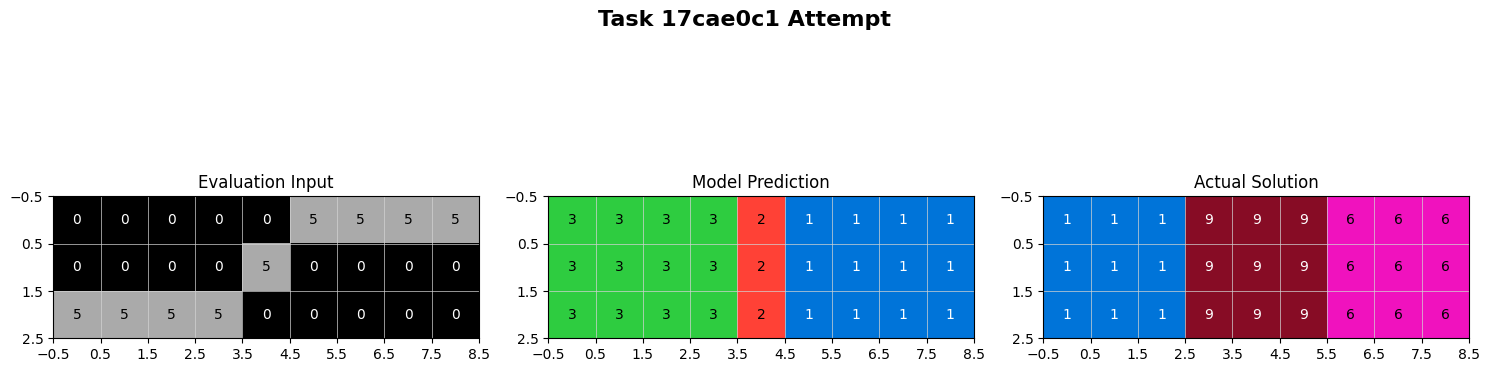


Prediction details for attempt_2, retry 0:
Prediction: [[3, 3, 3, 3, 2, 1, 1, 1, 1], [3, 3, 3, 3, 2, 1, 1, 1, 1], [3, 3, 3, 3, 2, 1, 1, 1, 1]]
Expected solution: [[1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6]]
2024-10-28 13:59:01,617 - INFO - Starting task #3 (2072aba6), pair #1
2024-10-28 13:59:01,619 - INFO - Plot flag for task 2072aba6, attempt 1, retry 0: True
2024-10-28 13:59:01,620 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 5, 0],
[5, 5, 5],
[0, 5, 0],]

Example 1: Output
[
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[1, 2, 1, 2, 1, 2],
[2, 1, 2, 1, 2, 1],
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],]

Example 2: Input
[
[5, 0, 0],
[0, 5, 0],
[0, 0, 5],]

Example 2: Output
[
[1, 2, 0, 0, 0, 0],
[2, 1, 0, 0, 0, 0],
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[0, 0, 0, 0, 1, 2],
[0, 0, 0, 0, 2, 1],]

Example 3: Input
[
[0, 5, 0],
[0, 5, 5],
[5, 5, 0],]

Example 3: Output
[
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[0, 0, 

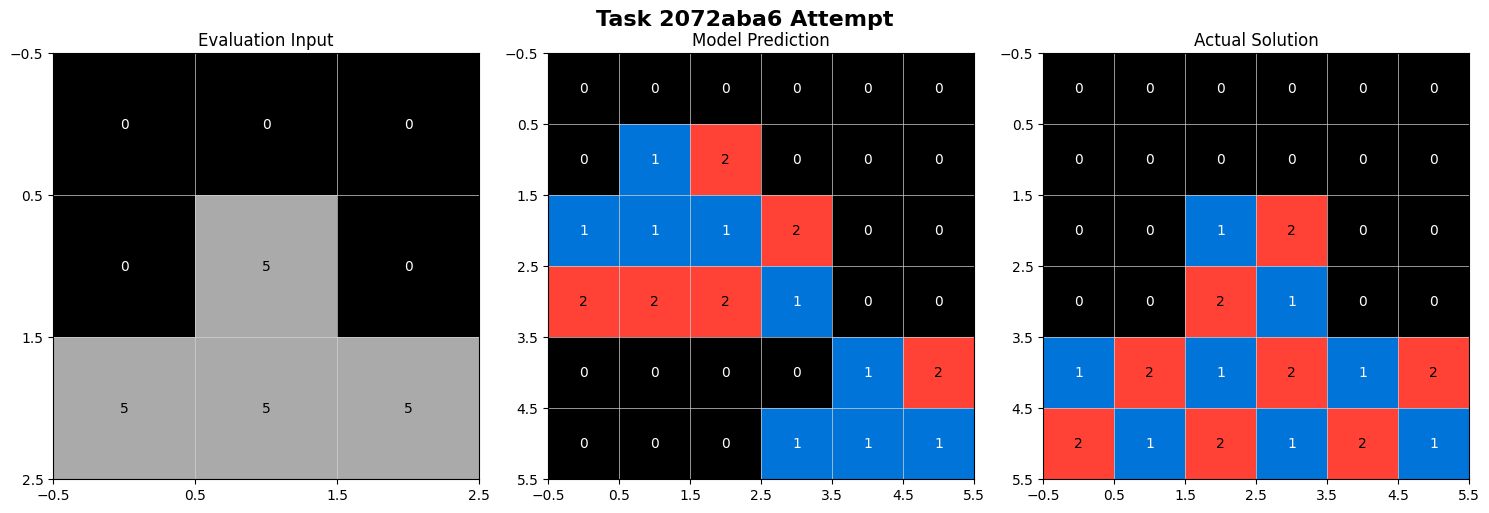


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 0, 0, 0, 0], [0, 1, 2, 0, 0, 0], [1, 1, 1, 2, 0, 0], [2, 2, 2, 1, 0, 0], [0, 0, 0, 0, 1, 2], [0, 0, 0, 1, 1, 1]]
Expected solution: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 2, 0, 0], [0, 0, 2, 1, 0, 0], [1, 2, 1, 2, 1, 2], [2, 1, 2, 1, 2, 1]]
2024-10-28 13:59:20,507 - INFO - Plot flag for task 2072aba6, attempt 2, retry 0: True
2024-10-28 13:59:20,508 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 5, 0],
[5, 5, 5],
[0, 5, 0],]

Example 1: Output
[
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[1, 2, 1, 2, 1, 2],
[2, 1, 2, 1, 2, 1],
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],]

Example 2: Input
[
[5, 0, 0],
[0, 5, 0],
[0, 0, 5],]

Example 2: Output
[
[1, 2, 0, 0, 0, 0],
[2, 1, 0, 0, 0, 0],
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[0, 0, 0, 0, 1, 2],
[0, 0, 0, 0, 2, 1],]

Example 3: Input
[
[0, 5, 0],
[0, 5, 5],
[5, 5, 0],]

Example 3: Output
[
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[0, 0, 1, 2

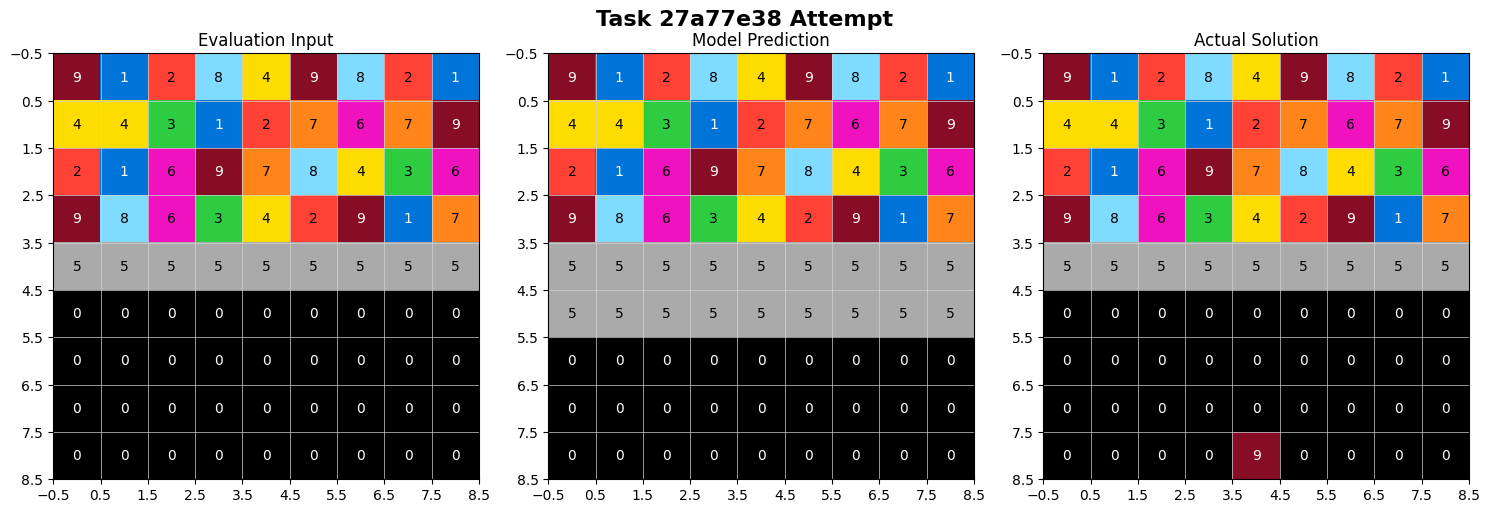


Prediction details for attempt_1, retry 0:
Prediction: [[9, 1, 2, 8, 4, 9, 8, 2, 1], [4, 4, 3, 1, 2, 7, 6, 7, 9], [2, 1, 6, 9, 7, 8, 4, 3, 6], [9, 8, 6, 3, 4, 2, 9, 1, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5], [5, 5, 5, 5, 5, 5, 5, 5, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Expected solution: [[9, 1, 2, 8, 4, 9, 8, 2, 1], [4, 4, 3, 1, 2, 7, 6, 7, 9], [2, 1, 6, 9, 7, 8, 4, 3, 6], [9, 8, 6, 3, 4, 2, 9, 1, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 9, 0, 0, 0, 0]]
2024-10-28 13:59:41,050 - INFO - Plot flag for task 27a77e38, attempt 2, retry 0: True
2024-10-28 13:59:41,051 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[2, 2, 3],
[5, 5, 5],
[0, 0, 0],]

Example 1: Output
[
[2, 2, 3],
[5, 5, 5],
[0, 2, 0],]

Example 2: Input
[
[3, 6, 4, 2, 4],
[8, 4, 3, 3, 4],
[5, 5, 5, 5, 5],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],]

Example 2: Output
[


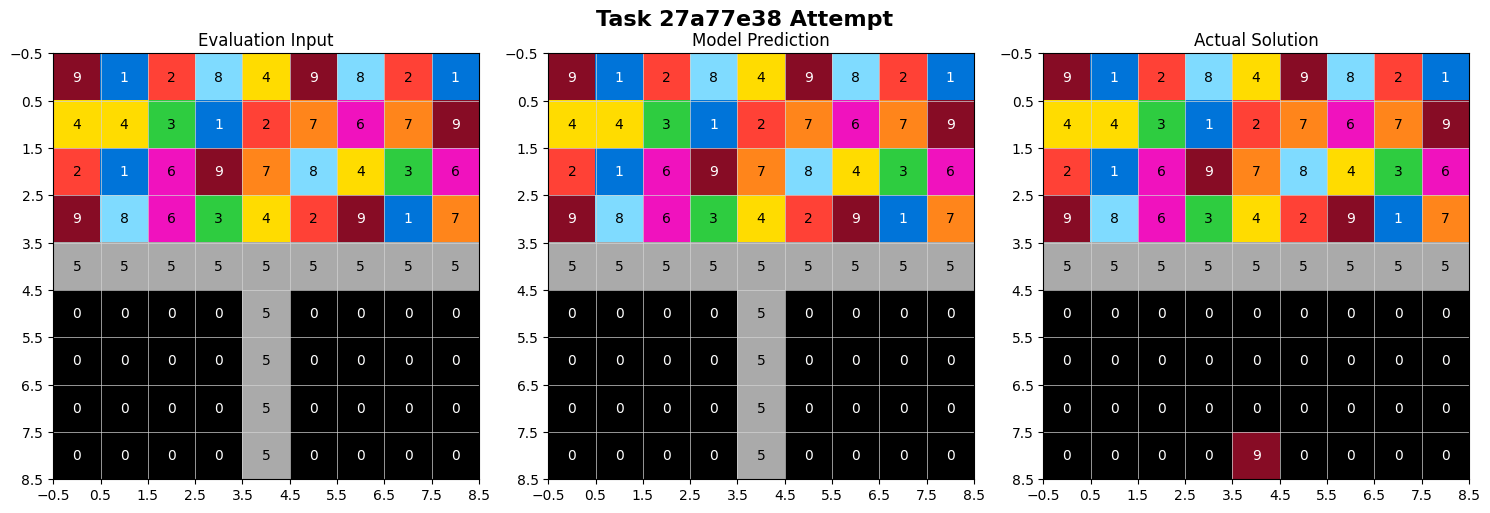


Prediction details for attempt_2, retry 0:
Prediction: [[9, 1, 2, 8, 4, 9, 8, 2, 1], [4, 4, 3, 1, 2, 7, 6, 7, 9], [2, 1, 6, 9, 7, 8, 4, 3, 6], [9, 8, 6, 3, 4, 2, 9, 1, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5], [0, 0, 0, 0, 5, 0, 0, 0, 0], [0, 0, 0, 0, 5, 0, 0, 0, 0], [0, 0, 0, 0, 5, 0, 0, 0, 0], [0, 0, 0, 0, 5, 0, 0, 0, 0]]
Expected solution: [[9, 1, 2, 8, 4, 9, 8, 2, 1], [4, 4, 3, 1, 2, 7, 6, 7, 9], [2, 1, 6, 9, 7, 8, 4, 3, 6], [9, 8, 6, 3, 4, 2, 9, 1, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 9, 0, 0, 0, 0]]
2024-10-28 13:59:54,409 - INFO - Starting task #5 (31d5ba1a), pair #1
2024-10-28 13:59:54,410 - INFO - Plot flag for task 31d5ba1a, attempt 1, retry 0: True
2024-10-28 13:59:54,412 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 0, 9, 0],
[9, 0, 0, 9, 0],
[0, 9, 9, 9, 9],
[4, 0, 0, 4, 0],
[4, 4, 0, 4, 4],
[4, 4, 4, 0, 4],]

Example 1: Output
[
[0, 6, 0, 0, 0],
[0, 6

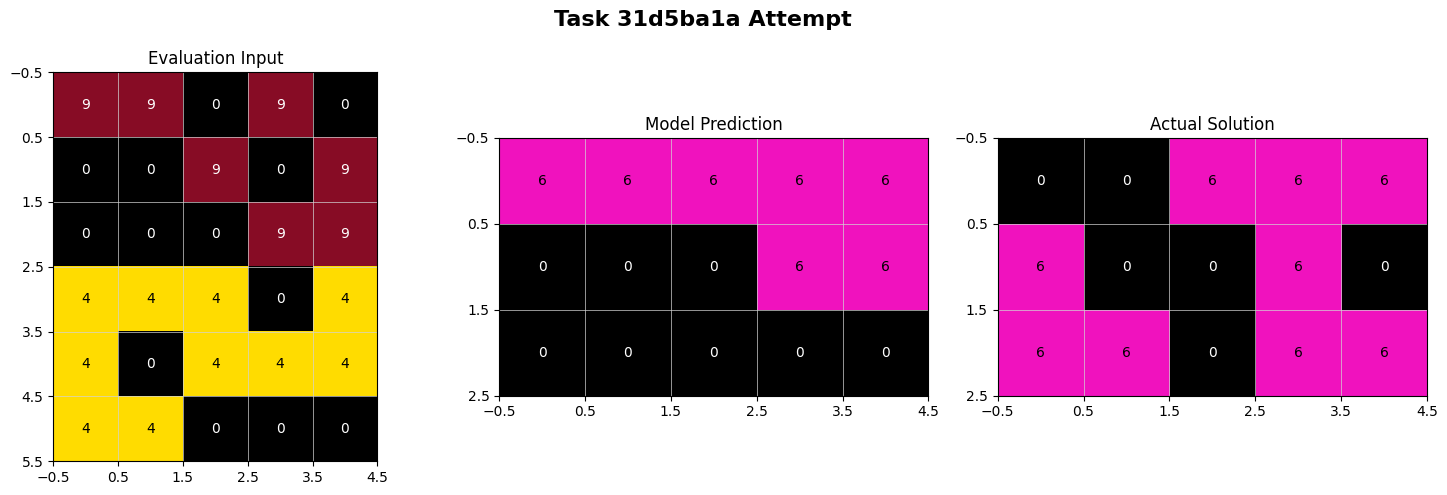


Prediction details for attempt_1, retry 0:
Prediction: [[6, 6, 6, 6, 6], [0, 0, 0, 6, 6], [0, 0, 0, 0, 0]]
Expected solution: [[0, 0, 6, 6, 6], [6, 0, 0, 6, 0], [6, 6, 0, 6, 6]]
2024-10-28 14:00:07,017 - INFO - Plot flag for task 31d5ba1a, attempt 2, retry 0: True
2024-10-28 14:00:07,019 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 0, 9, 0],
[9, 0, 0, 9, 0],
[0, 9, 9, 9, 9],
[4, 0, 0, 4, 0],
[4, 4, 0, 4, 4],
[4, 4, 4, 0, 4],]

Example 1: Output
[
[0, 6, 0, 0, 0],
[0, 6, 0, 0, 6],
[6, 0, 0, 6, 0],]

Example 2: Input
[
[9, 0, 0, 9, 9],
[0, 0, 0, 0, 0],
[0, 0, 9, 0, 9],
[0, 0, 4, 4, 0],
[4, 4, 4, 0, 0],
[4, 0, 4, 0, 4],]

Example 2: Output
[
[6, 0, 6, 0, 6],
[6, 6, 6, 0, 0],
[6, 0, 0, 0, 0],]

Example 3: Input
[
[0, 9, 0, 0, 0],
[0, 9, 9, 0, 9],
[9, 0, 0, 0, 9],
[4, 4, 0, 4, 0],
[0, 4, 4, 4, 0],
[4, 4, 0, 0, 0],]

Example 3: Output
[
[6, 0, 0, 6, 0],
[0, 0, 0, 6, 6],
[0, 6, 0, 0, 6],]

Example 4: Input
[
[0, 0, 9, 9, 0],
[9, 9, 0, 9, 9],
[0, 9, 0, 0, 0

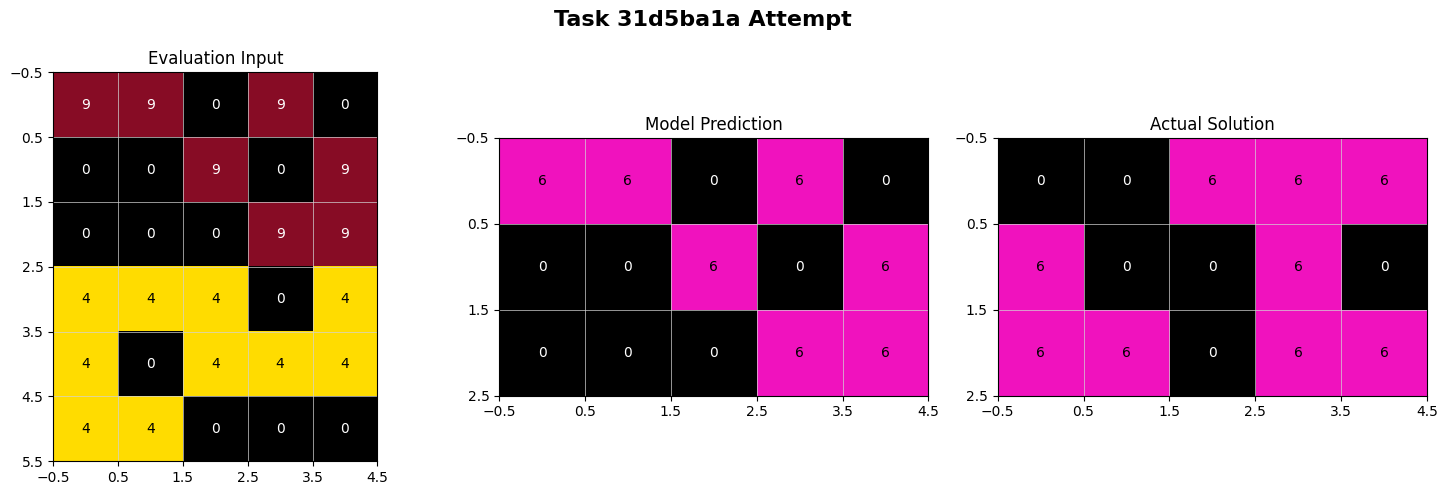


Prediction details for attempt_2, retry 0:
Prediction: [[6, 6, 0, 6, 0], [0, 0, 6, 0, 6], [0, 0, 0, 6, 6]]
Expected solution: [[0, 0, 6, 6, 6], [6, 0, 0, 6, 0], [6, 6, 0, 6, 6]]
2024-10-28 14:00:15,048 - INFO - Starting task #5 (31d5ba1a), pair #2
2024-10-28 14:00:15,048 - INFO - Plot flag for task 31d5ba1a, attempt 1, retry 0: True
2024-10-28 14:00:15,050 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 0, 9, 0],
[9, 0, 0, 9, 0],
[0, 9, 9, 9, 9],
[4, 0, 0, 4, 0],
[4, 4, 0, 4, 4],
[4, 4, 4, 0, 4],]

Example 1: Output
[
[0, 6, 0, 0, 0],
[0, 6, 0, 0, 6],
[6, 0, 0, 6, 0],]

Example 2: Input
[
[9, 0, 0, 9, 9],
[0, 0, 0, 0, 0],
[0, 0, 9, 0, 9],
[0, 0, 4, 4, 0],
[4, 4, 4, 0, 0],
[4, 0, 4, 0, 4],]

Example 2: Output
[
[6, 0, 6, 0, 6],
[6, 6, 6, 0, 0],
[6, 0, 0, 0, 0],]

Example 3: Input
[
[0, 9, 0, 0, 0],
[0, 9, 9, 0, 9],
[9, 0, 0, 0, 9],
[4, 4, 0, 4, 0],
[0, 4, 4, 4, 0],
[4, 4, 0, 0, 0],]

Example 3: Output
[
[6, 0, 0, 6, 0],
[0, 0, 0, 6, 6],
[0, 6, 0, 0, 6],

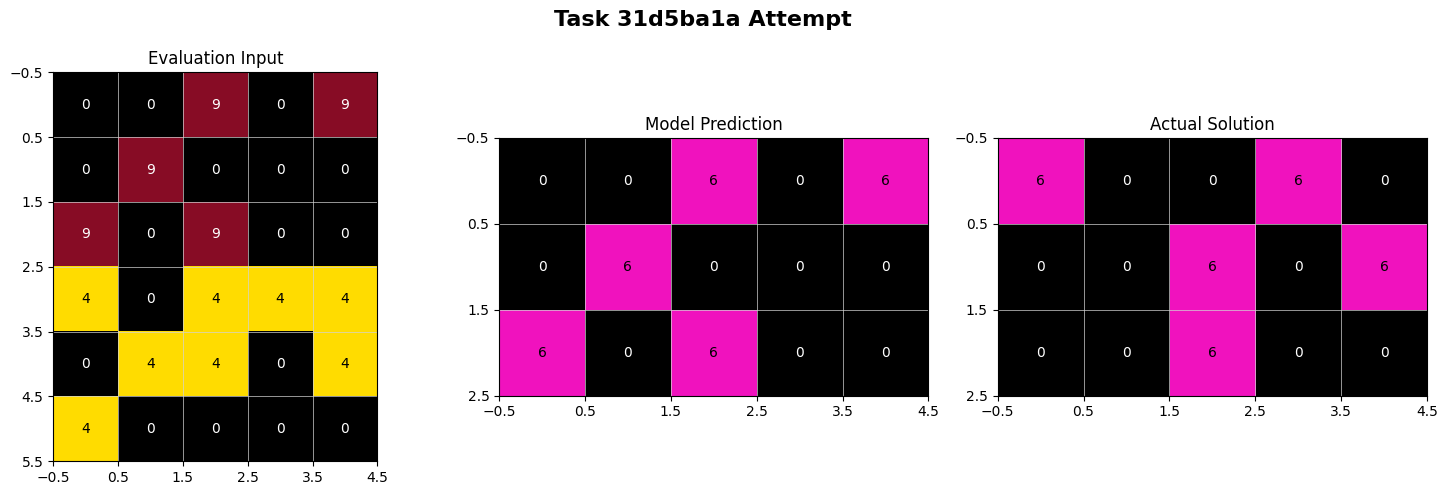


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 6, 0, 6], [0, 6, 0, 0, 0], [6, 0, 6, 0, 0]]
Expected solution: [[6, 0, 0, 6, 0], [0, 0, 6, 0, 6], [0, 0, 6, 0, 0]]
2024-10-28 14:00:28,315 - INFO - Plot flag for task 31d5ba1a, attempt 2, retry 0: True
2024-10-28 14:00:28,318 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 0, 9, 0],
[9, 0, 0, 9, 0],
[0, 9, 9, 9, 9],
[4, 0, 0, 4, 0],
[4, 4, 0, 4, 4],
[4, 4, 4, 0, 4],]

Example 1: Output
[
[0, 6, 0, 0, 0],
[0, 6, 0, 0, 6],
[6, 0, 0, 6, 0],]

Example 2: Input
[
[9, 0, 0, 9, 9],
[0, 0, 0, 0, 0],
[0, 0, 9, 0, 9],
[0, 0, 4, 4, 0],
[4, 4, 4, 0, 0],
[4, 0, 4, 0, 4],]

Example 2: Output
[
[6, 0, 6, 0, 6],
[6, 6, 6, 0, 0],
[6, 0, 0, 0, 0],]

Example 3: Input
[
[0, 9, 0, 0, 0],
[0, 9, 9, 0, 9],
[9, 0, 0, 0, 9],
[4, 4, 0, 4, 0],
[0, 4, 4, 4, 0],
[4, 4, 0, 0, 0],]

Example 3: Output
[
[6, 0, 0, 6, 0],
[0, 0, 0, 6, 6],
[0, 6, 0, 0, 6],]

Example 4: Input
[
[0, 0, 9, 9, 0],
[9, 9, 0, 9, 9],
[0, 9, 0, 0, 0

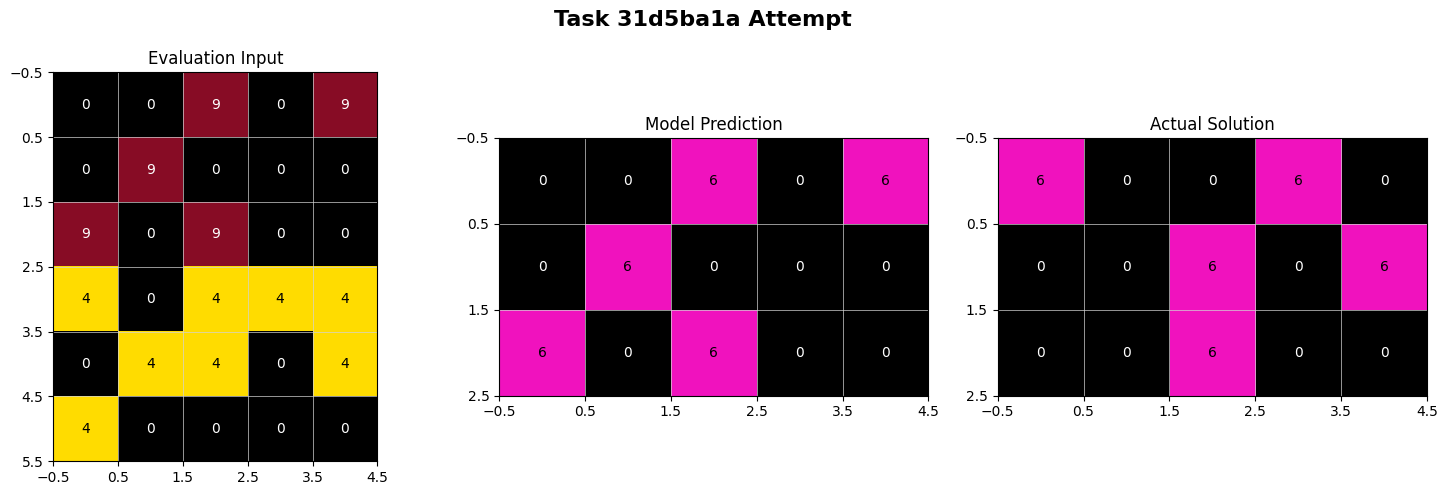


Prediction details for attempt_2, retry 0:
Prediction: [[0, 0, 6, 0, 6], [0, 6, 0, 0, 0], [6, 0, 6, 0, 0]]
Expected solution: [[6, 0, 0, 6, 0], [0, 0, 6, 0, 6], [0, 0, 6, 0, 0]]
2024-10-28 14:00:38,295 - INFO - Starting task #6 (34b99a2b), pair #1
2024-10-28 14:00:38,296 - INFO - Plot flag for task 34b99a2b, attempt 1, retry 0: True
2024-10-28 14:00:38,297 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 8, 0, 0, 4, 0, 5, 5, 0],
[8, 8, 0, 8, 4, 0, 0, 5, 5],
[0, 0, 0, 0, 4, 0, 0, 5, 0],
[8, 8, 0, 0, 4, 0, 5, 5, 5],
[8, 0, 0, 8, 4, 0, 0, 0, 5],]

Example 1: Output
[
[2, 0, 2, 0],
[2, 2, 2, 0],
[0, 0, 2, 0],
[2, 0, 2, 2],
[2, 0, 0, 0],]

Example 2: Input
[
[0, 8, 0, 0, 4, 5, 0, 5, 0],
[0, 8, 0, 8, 4, 5, 0, 5, 5],
[0, 8, 0, 8, 4, 0, 0, 0, 5],
[0, 8, 0, 8, 4, 0, 5, 0, 5],
[0, 0, 0, 8, 4, 0, 0, 5, 0],]

Example 2: Output
[
[2, 2, 2, 0],
[2, 2, 2, 0],
[0, 2, 0, 0],
[0, 0, 0, 0],
[0, 0, 2, 2],]

Example 3: Input
[
[0, 8, 0, 0, 4, 0, 5, 5, 0],
[8, 8, 0, 8, 4, 5, 0,

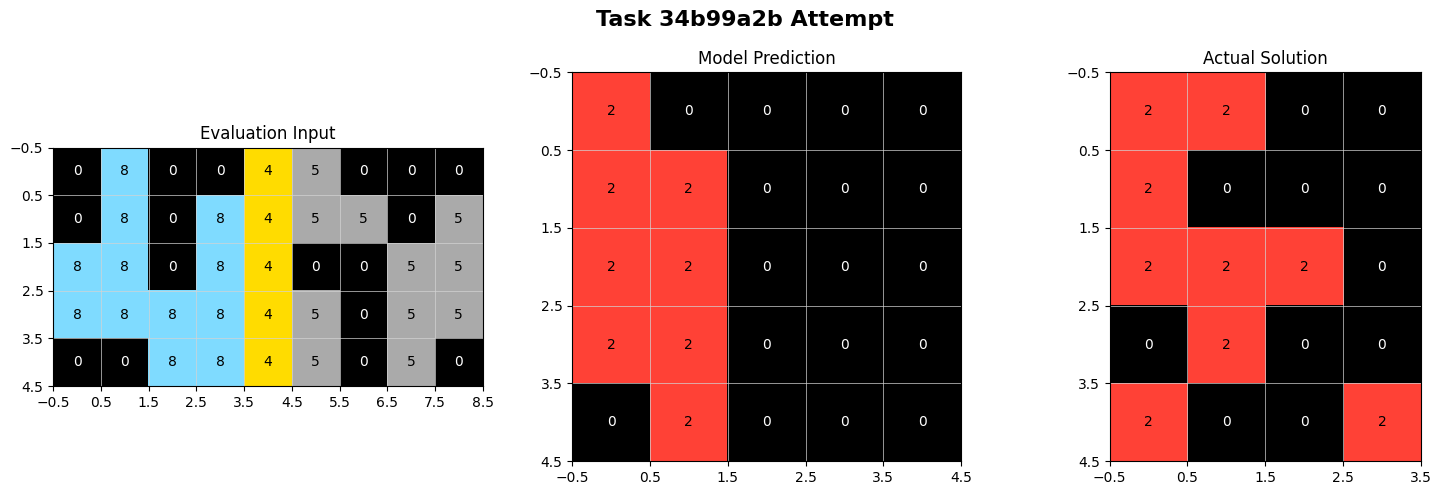


Prediction details for attempt_1, retry 0:
Prediction: [[2, 0, 0, 0, 0], [2, 2, 0, 0, 0], [2, 2, 0, 0, 0], [2, 2, 0, 0, 0], [0, 2, 0, 0, 0]]
Expected solution: [[2, 2, 0, 0], [2, 0, 0, 0], [2, 2, 2, 0], [0, 2, 0, 0], [2, 0, 0, 2]]
2024-10-28 14:00:50,734 - INFO - Plot flag for task 34b99a2b, attempt 2, retry 0: True
2024-10-28 14:00:50,736 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 8, 0, 0, 4, 0, 5, 5, 0],
[8, 8, 0, 8, 4, 0, 0, 5, 5],
[0, 0, 0, 0, 4, 0, 0, 5, 0],
[8, 8, 0, 0, 4, 0, 5, 5, 5],
[8, 0, 0, 8, 4, 0, 0, 0, 5],]

Example 1: Output
[
[2, 0, 2, 0],
[2, 2, 2, 0],
[0, 0, 2, 0],
[2, 0, 2, 2],
[2, 0, 0, 0],]

Example 2: Input
[
[0, 8, 0, 0, 4, 5, 0, 5, 0],
[0, 8, 0, 8, 4, 5, 0, 5, 5],
[0, 8, 0, 8, 4, 0, 0, 0, 5],
[0, 8, 0, 8, 4, 0, 5, 0, 5],
[0, 0, 0, 8, 4, 0, 0, 5, 0],]

Example 2: Output
[
[2, 2, 2, 0],
[2, 2, 2, 0],
[0, 2, 0, 0],
[0, 0, 0, 0],
[0, 0, 2, 2],]

Example 3: Input
[
[0, 8, 0, 0, 4, 0, 5, 5, 0],
[8, 8, 0, 8, 4, 5, 0, 0, 5],
[8, 8, 0,

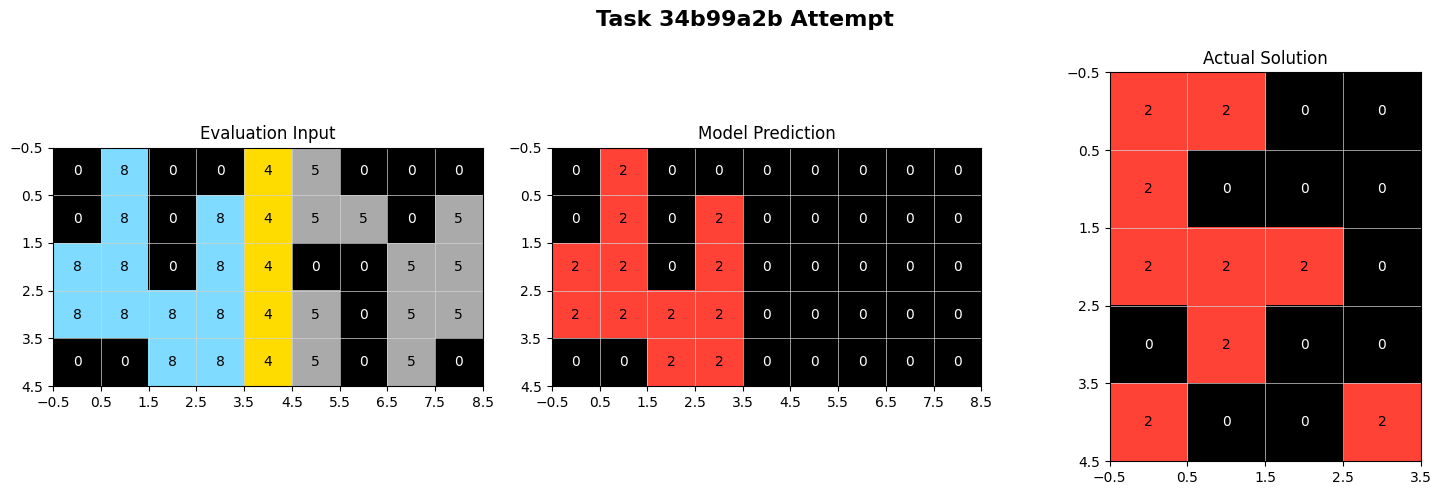


Prediction details for attempt_2, retry 0:
Prediction: [[0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 2, 0, 0, 0, 0, 0], [2, 2, 0, 2, 0, 0, 0, 0, 0], [2, 2, 2, 2, 0, 0, 0, 0, 0], [0, 0, 2, 2, 0, 0, 0, 0, 0]]
Expected solution: [[2, 2, 0, 0], [2, 0, 0, 0], [2, 2, 2, 0], [0, 2, 0, 0], [2, 0, 0, 2]]
2024-10-28 14:00:59,542 - INFO - Starting task #7 (4cd1b7b2), pair #1
2024-10-28 14:00:59,544 - INFO - Plot flag for task 4cd1b7b2, attempt 1, retry 0: True
2024-10-28 14:00:59,548 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[1, 0, 3, 4],
[0, 0, 2, 1],
[2, 1, 4, 0],
[0, 3, 1, 2],]

Example 1: Output
[
[1, 2, 3, 4],
[3, 4, 2, 1],
[2, 1, 4, 3],
[4, 3, 1, 2],]

Example 2: Input
[
[0, 4, 2, 3],
[4, 1, 0, 2],
[0, 3, 4, 0],
[3, 0, 1, 4],]

Example 2: Output
[
[1, 4, 2, 3],
[4, 1, 3, 2],
[2, 3, 4, 1],
[3, 2, 1, 4],]

Example 3: Input
[
[3, 0, 2, 1],
[1, 0, 0, 0],
[4, 3, 0, 2],
[0, 1, 4, 3],]

Example 3: Output
[
[3, 4, 2, 1],
[1, 2, 3, 4],
[4, 3, 1, 2],
[2, 1, 4, 3],]

Test
[


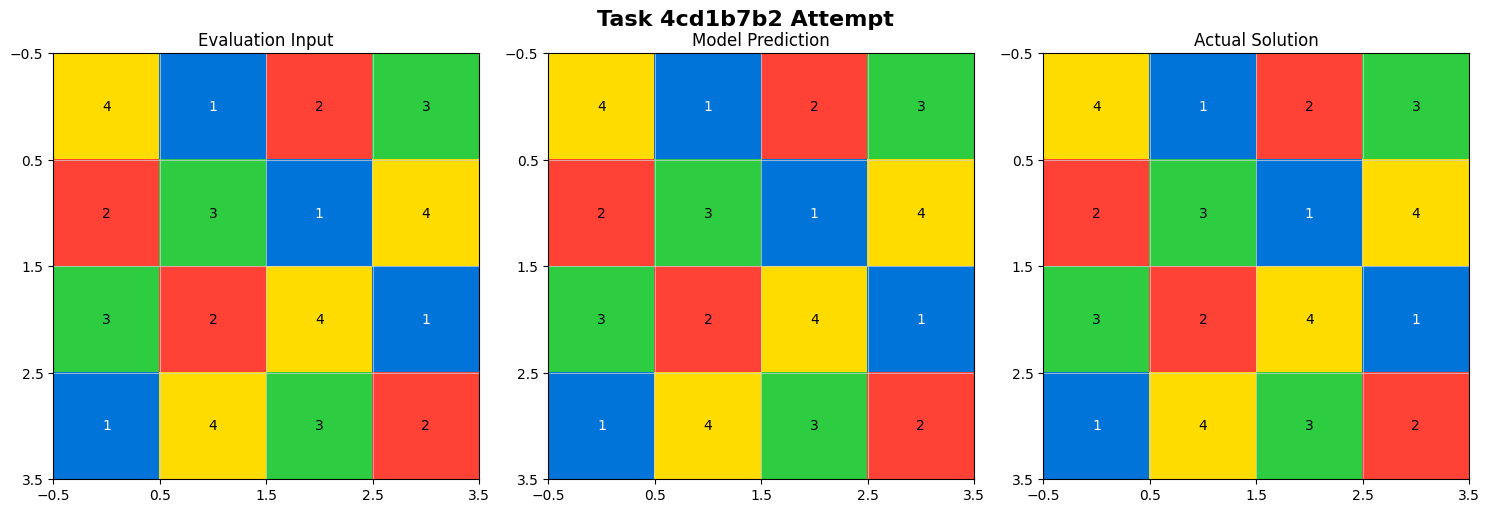


Prediction details for attempt_1, retry 0:
Prediction: [[4, 1, 2, 3], [2, 3, 1, 4], [3, 2, 4, 1], [1, 4, 3, 2]]
Expected solution: [[4, 1, 2, 3], [2, 3, 1, 4], [3, 2, 4, 1], [1, 4, 3, 2]]
Found correct solution in attempt_1, retry 0
2024-10-28 14:01:11,984 - INFO - Plot flag for task 4cd1b7b2, attempt 2, retry 0: True
2024-10-28 14:01:11,989 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[1, 0, 3, 4],
[0, 0, 2, 1],
[2, 1, 4, 0],
[0, 3, 1, 2],]

Example 1: Output
[
[1, 2, 3, 4],
[3, 4, 2, 1],
[2, 1, 4, 3],
[4, 3, 1, 2],]

Example 2: Input
[
[0, 4, 2, 3],
[4, 1, 0, 2],
[0, 3, 4, 0],
[3, 0, 1, 4],]

Example 2: Output
[
[1, 4, 2, 3],
[4, 1, 3, 2],
[2, 3, 4, 1],
[3, 2, 1, 4],]

Example 3: Input
[
[3, 0, 2, 1],
[1, 0, 0, 0],
[4, 3, 0, 2],
[0, 1, 4, 3],]

Example 3: Output
[
[3, 4, 2, 1],
[1, 2, 3, 4],
[4, 3, 1, 2],
[2, 1, 4, 3],]

Test
[
[4, 1, 2, 3]
[2, 3, 1, 4]
[3, 2, 4, 1]
[1, 4, 3, 2]]

Your Response: with predicted grid size: Unknown
Debug - Plotting dimensio

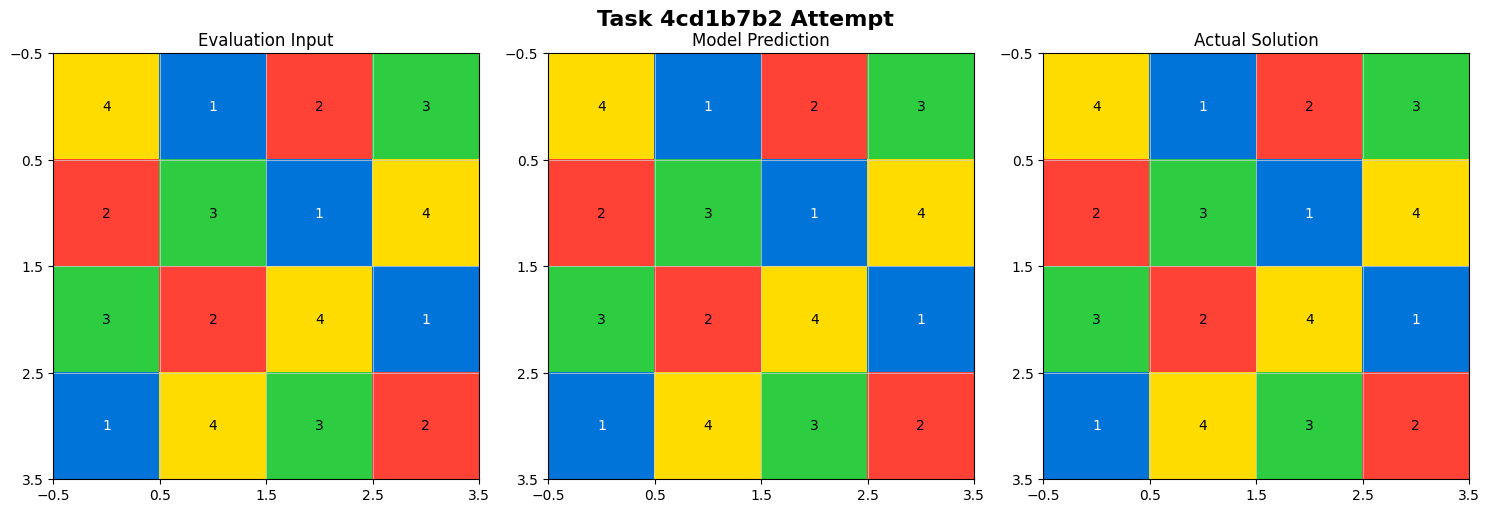


Prediction details for attempt_2, retry 0:
Prediction: [[4, 1, 2, 3], [2, 3, 1, 4], [3, 2, 4, 1], [1, 4, 3, 2]]
Expected solution: [[4, 1, 2, 3], [2, 3, 1, 4], [3, 2, 4, 1], [1, 4, 3, 2]]
Found correct solution in attempt_2, retry 0
2024-10-28 14:01:31,789 - INFO - Starting task #8 (59341089), pair #1
2024-10-28 14:01:31,790 - INFO - Plot flag for task 59341089, attempt 1, retry 0: True
2024-10-28 14:01:31,792 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[7, 5, 7],
[5, 5, 7],
[7, 7, 5],]

Example 1: Output
[
[7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7],
[7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7],
[5, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7, 5],]

Example 2: Input
[
[7, 7, 8],
[5, 8, 8],
[5, 8, 8],]

Example 2: Output
[
[8, 7, 7, 7, 7, 8, 8, 7, 7, 7, 7, 8],
[8, 8, 5, 5, 8, 8, 8, 8, 5, 5, 8, 8],
[8, 8, 5, 5, 8, 8, 8, 8, 5, 5, 8, 8],]

Example 3: Input
[
[8, 8, 8],
[5, 5, 7],
[5, 7, 8],]

Example 3: Output
[
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
[7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7],


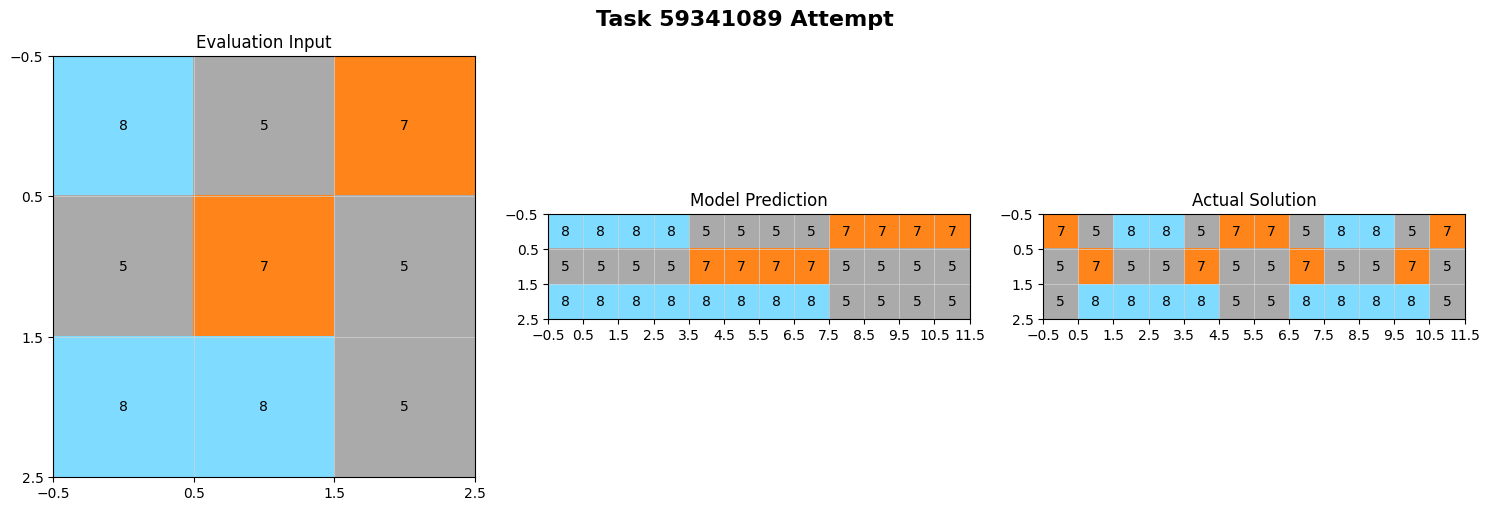


Prediction details for attempt_1, retry 0:
Prediction: [[8, 8, 8, 8, 5, 5, 5, 5, 7, 7, 7, 7], [5, 5, 5, 5, 7, 7, 7, 7, 5, 5, 5, 5], [8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5]]
Expected solution: [[7, 5, 8, 8, 5, 7, 7, 5, 8, 8, 5, 7], [5, 7, 5, 5, 7, 5, 5, 7, 5, 5, 7, 5], [5, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 5]]
2024-10-28 14:01:39,617 - INFO - Plot flag for task 59341089, attempt 2, retry 0: True
2024-10-28 14:01:39,619 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[7, 5, 7],
[5, 5, 7],
[7, 7, 5],]

Example 1: Output
[
[7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7],
[7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7],
[5, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7, 5],]

Example 2: Input
[
[7, 7, 8],
[5, 8, 8],
[5, 8, 8],]

Example 2: Output
[
[8, 7, 7, 7, 7, 8, 8, 7, 7, 7, 7, 8],
[8, 8, 5, 5, 8, 8, 8, 8, 5, 5, 8, 8],
[8, 8, 5, 5, 8, 8, 8, 8, 5, 5, 8, 8],]

Example 3: Input
[
[8, 8, 8],
[5, 5, 7],
[5, 7, 8],]

Example 3: Output
[
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
[7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7],

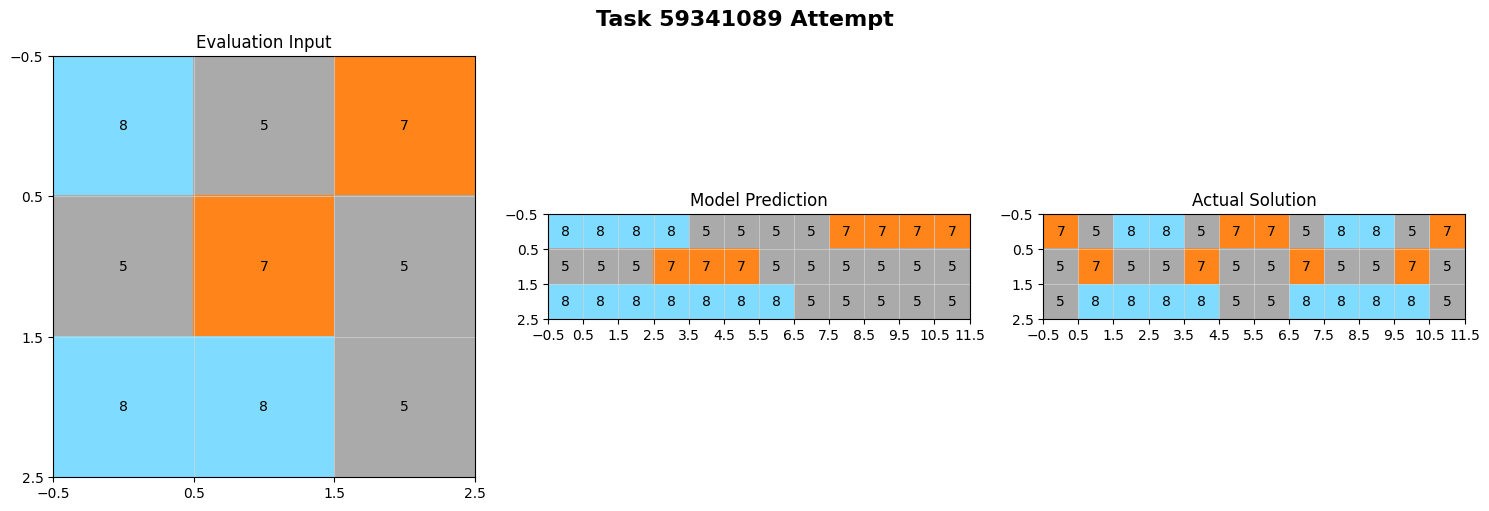


Prediction details for attempt_2, retry 0:
Prediction: [[8, 8, 8, 8, 5, 5, 5, 5, 7, 7, 7, 7], [5, 5, 5, 7, 7, 7, 5, 5, 5, 5, 5, 5], [8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5]]
Expected solution: [[7, 5, 8, 8, 5, 7, 7, 5, 8, 8, 5, 7], [5, 7, 5, 5, 7, 5, 5, 7, 5, 5, 7, 5], [5, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 5]]
2024-10-28 14:01:55,790 - INFO - Starting task #9 (62b74c02), pair #1
2024-10-28 14:01:55,791 - INFO - Plot flag for task 62b74c02, attempt 1, retry 0: True
2024-10-28 14:01:55,793 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 2, 8, 0, 0, 0, 0, 0, 0, 0],
[1, 8, 1, 0, 0, 0, 0, 0, 0, 0],
[1, 8, 1, 0, 0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[8, 2, 8, 8, 8, 8, 8, 8, 2, 8],
[1, 8, 1, 1, 1, 1, 1, 1, 8, 1],
[1, 8, 1, 1, 1, 1, 1, 1, 8, 1],]

Example 2: Input
[
[3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 

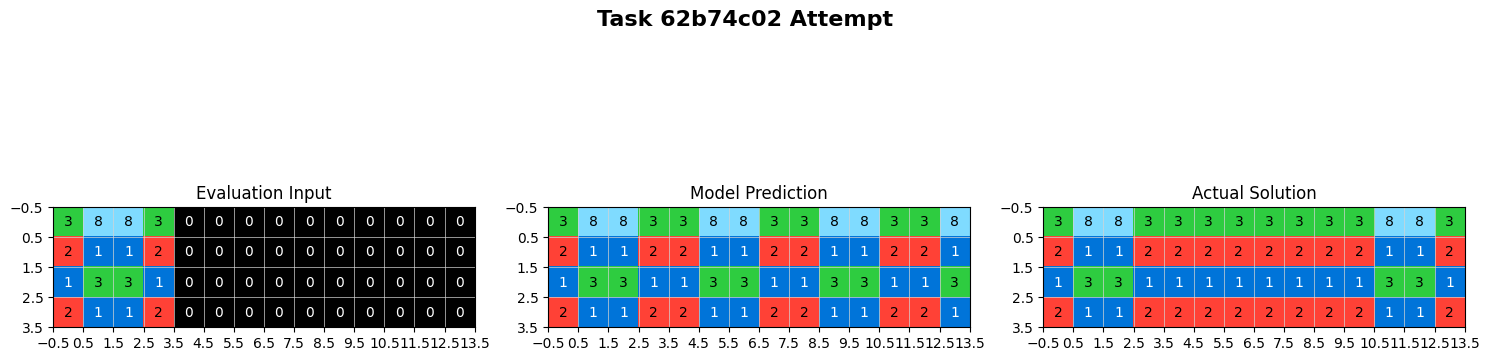


Prediction details for attempt_1, retry 0:
Prediction: [[3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8], [2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1], [1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3], [2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1]]
Expected solution: [[3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3], [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2], [1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1], [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2]]
2024-10-28 14:02:07,028 - INFO - Plot flag for task 62b74c02, attempt 2, retry 0: True
2024-10-28 14:02:07,029 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 2, 8, 0, 0, 0, 0, 0, 0, 0],
[1, 8, 1, 0, 0, 0, 0, 0, 0, 0],
[1, 8, 1, 0, 0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[8, 2, 8, 8, 8, 8, 8, 8, 2, 8],
[1, 8, 1, 1, 1, 1, 1, 1, 8, 1],
[1, 8, 1, 1, 1, 1, 1, 1, 8, 1],]

Example 2: Input
[
[3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],

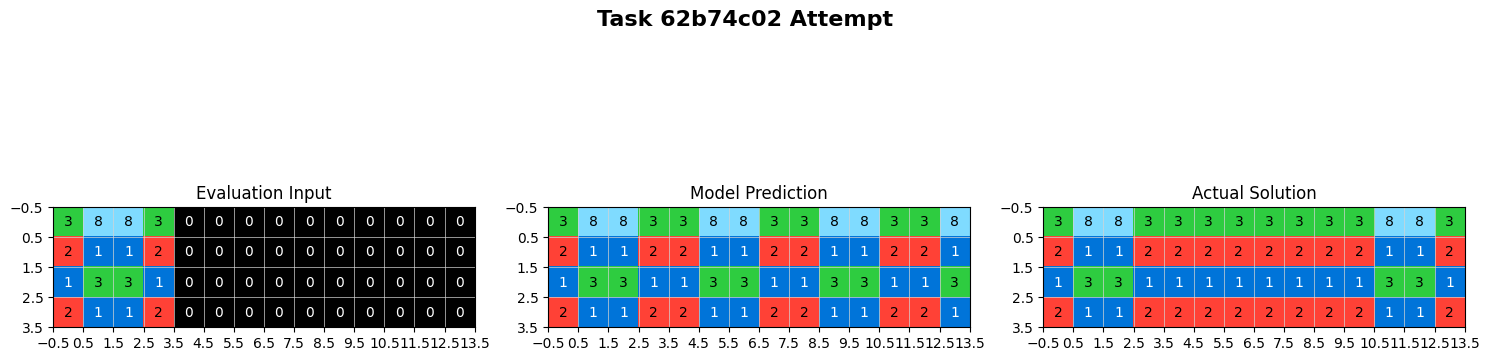


Prediction details for attempt_2, retry 0:
Prediction: [[3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8], [2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1], [1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3], [2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1]]
Expected solution: [[3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3], [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2], [1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1], [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2]]
2024-10-28 14:03:21,398 - INFO - Starting task #10 (66e6c45b), pair #1
2024-10-28 14:03:21,400 - INFO - Plot flag for task 66e6c45b, attempt 1, retry 0: True
2024-10-28 14:03:21,403 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0],
[0, 3, 4, 0],
[0, 7, 6, 0],
[0, 0, 0, 0],]

Example 1: Output
[
[3, 0, 0, 4],
[0, 0, 0, 0],
[0, 0, 0, 0],
[7, 0, 0, 6],]

Example 2: Input
[
[0, 0, 0, 0],
[0, 5, 6, 0],
[0, 8, 3, 0],
[0, 0, 0, 0],]

Example 2: Output
[
[5, 0, 0, 6],
[0, 0, 0, 0],
[0, 0, 0, 0],
[8, 0, 0, 3],]

Test
[
[0, 0, 0, 0]
[0, 

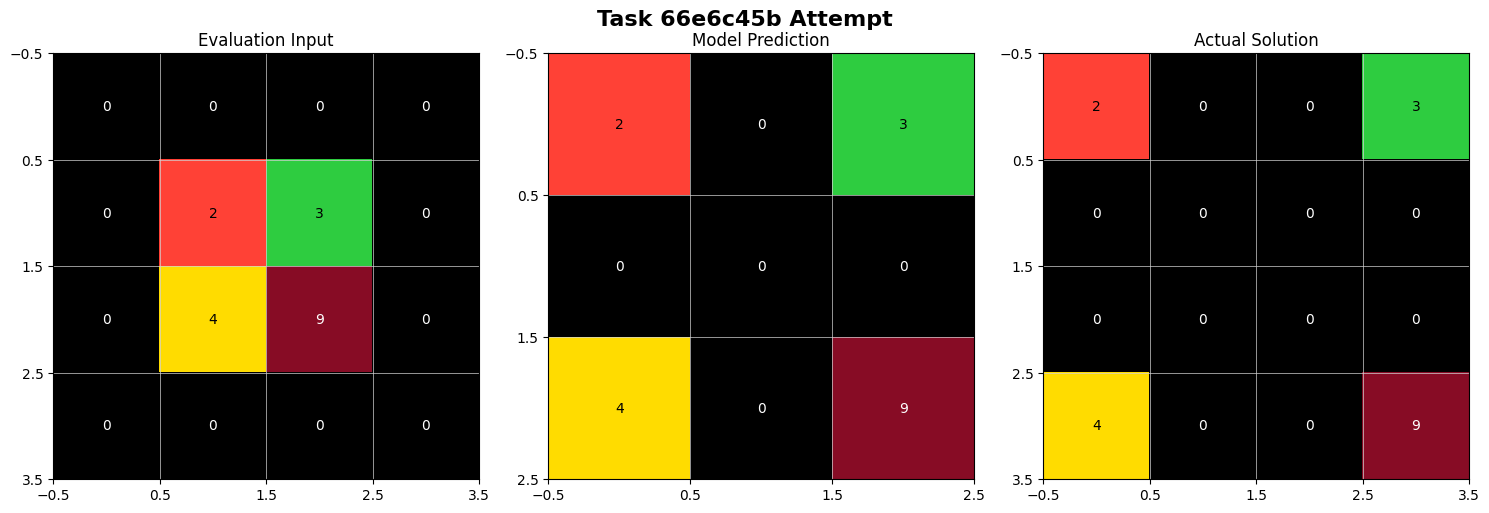


Prediction details for attempt_1, retry 0:
Prediction: [[2, 0, 3], [0, 0, 0], [4, 0, 9]]
Expected solution: [[2, 0, 0, 3], [0, 0, 0, 0], [0, 0, 0, 0], [4, 0, 0, 9]]
2024-10-28 14:03:33,153 - INFO - Plot flag for task 66e6c45b, attempt 2, retry 0: True
2024-10-28 14:03:33,155 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0],
[0, 3, 4, 0],
[0, 7, 6, 0],
[0, 0, 0, 0],]

Example 1: Output
[
[3, 0, 0, 4],
[0, 0, 0, 0],
[0, 0, 0, 0],
[7, 0, 0, 6],]

Example 2: Input
[
[0, 0, 0, 0],
[0, 5, 6, 0],
[0, 8, 3, 0],
[0, 0, 0, 0],]

Example 2: Output
[
[5, 0, 0, 6],
[0, 0, 0, 0],
[0, 0, 0, 0],
[8, 0, 0, 3],]

Test
[
[0, 0, 0, 0]
[0, 2, 3, 0]
[0, 4, 9, 0]
[0, 0, 0, 0]]

Your Response: with predicted grid size: Unknown
Debug - Plotting dimensions:
Test input shape: (4, 4)
Predicted solution shape: (4, 4)
Actual solution shape: (4, 4)
2024-10-28 14:03:41,906 - INFO - Plotting results for task 66e6c45b, attempt 0


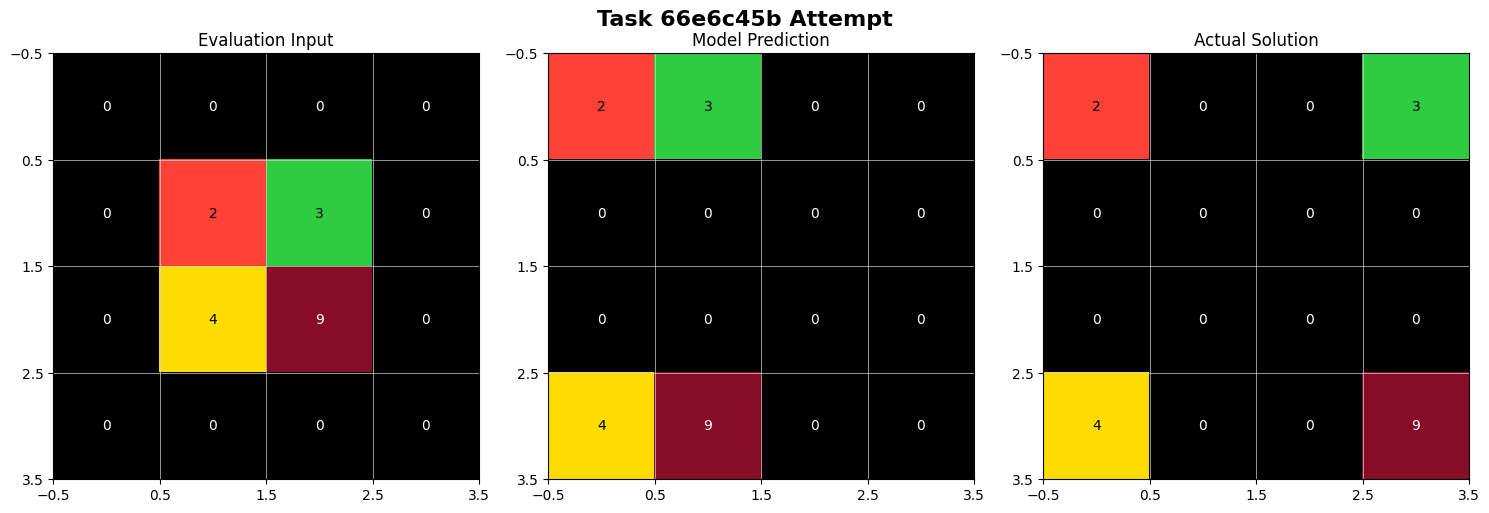


Prediction details for attempt_2, retry 0:
Prediction: [[2, 3, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [4, 9, 0, 0]]
Expected solution: [[2, 0, 0, 3], [0, 0, 0, 0], [0, 0, 0, 0], [4, 0, 0, 9]]
Submission saved to submission.json
Scoring submission.json

Submission contents:
{
  "00576224": [
    {
      "attempt_1": [
        [
          2,
          2,
          2,
          3,
          3,
          3
        ],
        [
          3,
          3,
          3,
          2,
          2,
          2
        ],
        [
          2,
          2,
          2,
          3,
          3,
          3
        ],
        [
          7,
          7,
          7,
          8,
          8,
          8
        ],
        [
          7,
          7,
          7,
          8,
          8,
          8
        ],
        [
          8,
          8,
          8,
          7,
          7,
          7
        ]
      ],
      "attempt_2": [
        [
          3,
          2,
          3,
          2,
     

In [220]:
main(task_set='evaluation', NUM_TASKS=10)